In [1]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(10)

C:\Users\wangj\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [1]:
import keras
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, Activation
from keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image
from keras.wrappers.scikit_learn import KerasClassifier
from scipy.stats import randint as sp_randint
from sklearn.model_selection import ParameterSampler
import time
from keras.callbacks import History 
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import warnings

# deal with potential warnings
warnings.filterwarnings(action='ignore')

C:\Users\wangj\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


read processed array data, usually takes 1 or 2 minutes.

In [2]:
data1 = np.load('data/data21.npy')
data2 = np.load('data/data22.npy')
data3 = np.load('data/data23.npy')
data4 = np.load('data/data24.npy')
# data5 = np.load('data/data5.npy')
data = np.concatenate((data1,data2,data3,data4))
x_test = np.load('data/testdata2.npy')
testID = np.load('data/testdata2ID.npy')

train/test split and normalization

In [3]:
# train/test ratio
ratio = 0.8

# shuffle dataset
np.random.shuffle(data)
x_train = []
y_train = []
x_dev = []
y_dev = []
for index,item in enumerate(data):
    if index<len(data)*ratio:
        x_train.append(item[0])
        y_train.append(item[1])
    else:
        x_dev.append(item[0])
        y_dev.append(item[1])
    
x_train = np.asarray(x_train)
x_dev = np.asarray(x_dev)
y_train = np.asarray(y_train)
y_dev = np.asarray(y_dev)
x_test = np.asarray(x_test)

# normalize input
x_train /= 255
x_dev /= 255
x_test /= 255

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, 2)[:,-1]
y_dev = keras.utils.to_categorical(y_dev, 2)[:,-1]

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print('x_dev shape:', x_dev.shape)
print(x_dev.shape[0], 'validtion samples')
print('x_test shape:', x_test.shape)

x_train shape: (15002, 64, 64, 3)
15002 train samples
x_dev shape: (3750, 64, 64, 3)
3750 validtion samples
x_test shape: (6248, 64, 64, 3)


CNN architecture

In [4]:
def create_model(lr=0.001, dropout_rate=[0.5], alpha=0.0001):
    model = Sequential()
    
    model.add(Conv2D(16, (3, 3), strides = (1, 1), input_shape=(64, 64, 3), border_mode='same', W_regularizer=regularizers.l2(alpha)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(16, (3, 3), strides = (1, 1), border_mode='same', W_regularizer=regularizers.l2(alpha)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    model.add(Conv2D(32, (3, 3), strides = (1, 1), border_mode='same', W_regularizer=regularizers.l2(alpha)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3), strides = (1, 1), border_mode='same', W_regularizer=regularizers.l2(alpha)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    model.add(Conv2D(64, (3, 3), strides = (1, 1), border_mode='same', W_regularizer=regularizers.l2(alpha)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3), strides = (1, 1), border_mode='same', W_regularizer=regularizers.l2(alpha)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3), strides = (1, 1), border_mode='same', W_regularizer=regularizers.l2(alpha)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    model.add(Conv2D(128, (3, 3), strides = (1, 1), border_mode='same', W_regularizer=regularizers.l2(alpha)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3), strides = (1, 1), border_mode='same', W_regularizer=regularizers.l2(alpha)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3), strides = (1, 1), border_mode='same', W_regularizer=regularizers.l2(alpha)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(dropout_rate[0]))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(dropout_rate[-1]))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss=keras.losses.binary_crossentropy,
                  optimizer=keras.optimizers.Adam(lr=lr, amsgrad=True),
                  metrics=['accuracy'])
        
    return model

Training process

In [5]:
# callbacks, early-stopping
callbacks = keras.callbacks.ModelCheckpoint('my_model.h5', 
                                             monitor='val_acc', verbose=1, save_best_only=True, 
                                             save_weights_only=False, mode='auto', period=1)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1)

callback_list = [callbacks]

# hyper-parameters
param = {'lr':[0.001],
#          'batch_size':np.power(2,np.arange(5,7)),
         'dropout_rate':np.round(np.arange(0.4,0.9,0.1),1)}

param_list = list(ParameterSampler(param, n_iter=5))
rounded_list = [dict((k, v) for (k, v) in d.items()) for d in param_list]
print(rounded_list)

[{'lr': 0.001, 'dropout_rate': 0.4}, {'lr': 0.001, 'dropout_rate': 0.5}, {'lr': 0.001, 'dropout_rate': 0.6}, {'lr': 0.001, 'dropout_rate': 0.7}, {'lr': 0.001, 'dropout_rate': 0.8}]


In [ ]:
# sklearn wrapper training
model = KerasClassifier(build_fn=create_model, verbose=1, 
                        epochs=100,
                        lr=0.001,
                        batch_size=64,
                        dropout_rate=[0.7],
                        alpha=0.01,
                        validation_data=(x_dev,y_dev),
                        callbacks=callback_list)
train_history = model.fit(x_train, y_train)
#     model.model.save('my_model_1.h5')

In [ ]:
# continue training
temp_weights = [layer.get_weights() for layer in new_model.layers]
model = create_model(lr=0.0001,
                     dropout_rate=[0.7],
                     alpha=0.01)
for j in range(len(temp_weights)):
    model.layers[j].set_weights(temp_weights[j])
    
train_history = model.fit(x_train, y_train, verbose=1,
                          batch_size=64,
                          validation_data=(x_dev,y_dev), 
                          epochs=50,
                          callbacks=callback_list)

In [10]:
temp_weights = [layer.get_weights() for layer in new_model.layers]

model = create_model(lr=0.00001,
                     dropout_rate=[0.7, 0.7],
                     alpha=0.0)

for j in range(len(temp_weights)):
    model.layers[j].set_weights(temp_weights[j])

datagen = ImageDataGenerator(zoom_range=0.2,
                             rotation_range=20,
                             horizontal_flip=True)

datagen.fit(x_train)

model.fit_generator(datagen.flow(x_train, y_train, batch_size=32), 
                    verbose=1,
                    steps_per_epoch=len(x_train) // 32,
                    validation_data=(x_dev,y_dev), 
                    epochs=100,
                    callbacks=callback_list)

Epoch 1/100
468/468 [==============================] - 41s 88ms/step - loss: 0.0941 - acc: 0.9641 - val_loss: 0.2035 - val_acc: 0.9152

Epoch 00001: val_acc did not improve
Epoch 2/100
468/468 [==============================] - 39s 83ms/step - loss: 0.0960 - acc: 0.9621 - val_loss: 0.1816 - val_acc: 0.9245

Epoch 00002: val_acc improved from 0.91893 to 0.92453, saving model to my_model.h5
Epoch 3/100
468/468 [==============================] - 39s 84ms/step - loss: 0.0939 - acc: 0.9631 - val_loss: 0.1873 - val_acc: 0.9211

Epoch 00003: val_acc did not improve
Epoch 4/100
468/468 [==============================] - 40s 85ms/step - loss: 0.0935 - acc: 0.9635 - val_loss: 0.1817 - val_acc: 0.9243

Epoch 00004: val_acc did not improve
Epoch 5/100
468/468 [==============================] - 40s 85ms/step - loss: 0.0939 - acc: 0.9623 - val_loss: 0.1805 - val_acc: 0.9248

Epoch 00005: val_acc improved from 0.92453 to 0.92480, saving model to my_model.h5
Epoch 6/100
468/468 [======================

468/468 [==============================] - 39s 82ms/step - loss: 0.0757 - acc: 0.9716 - val_loss: 0.1874 - val_acc: 0.9253

Epoch 00047: val_acc did not improve
Epoch 48/100
468/468 [==============================] - 38s 82ms/step - loss: 0.0722 - acc: 0.9709 - val_loss: 0.1811 - val_acc: 0.9267

Epoch 00048: val_acc did not improve
Epoch 49/100
468/468 [==============================] - 38s 82ms/step - loss: 0.0731 - acc: 0.9718 - val_loss: 0.2055 - val_acc: 0.9189

Epoch 00049: val_acc did not improve
Epoch 50/100
468/468 [==============================] - 38s 82ms/step - loss: 0.0733 - acc: 0.9720 - val_loss: 0.1796 - val_acc: 0.9280

Epoch 00050: val_acc did not improve
Epoch 51/100
468/468 [==============================] - 39s 82ms/step - loss: 0.0729 - acc: 0.9722 - val_loss: 0.1872 - val_acc: 0.9261

Epoch 00051: val_acc did not improve
Epoch 52/100
468/468 [==============================] - 38s 82ms/step - loss: 0.0688 - acc: 0.9732 - val_loss: 0.1824 - val_acc: 0.9277

Epoch 

evaluation

In [ ]:
%matplotlib inline
# model.model.save('my_model.h5')
# print(train_history.history)
# print(train_history.history['val_loss'][-1])
plt.plot(train_history.history['acc'])
plt.plot(train_history.history['val_acc'])
plt.grid(True)
plt.show()

offline working

In [11]:
new_model = load_model('my_model.h5')
# new_model.model.summary()

In [12]:
# predict on test set 
score = np.round(new_model.predict(x_test, verbose=1)).astype(np.int32)
# score = np.clip(score, a_min=0.05, a_max=0.95)

6248/6248 [==============================] - 6s 931us/step


In [13]:
sub = pd.DataFrame()
sub['id'] = pd.Series(testID)
sub['label'] = score
sub.to_csv('DvCsubmission.csv', index = False)

Try some other fur balls!

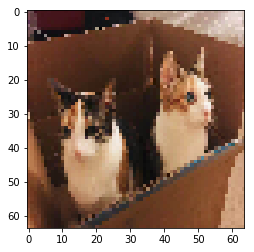

cat


In [26]:
img_path = 'pics/2kitty.jpg'
img = image.load_img(img_path, target_size=(64, 64))
x = image.img_to_array(img) / 255
plt.imshow(x)
plt.show()
x = np.expand_dims(x, axis=0)
# print(model.predict(x))
print(['cat', 'dog'][int(model.predict(x))])